In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_excel('daily_offers.xlsx')
print(data.shape)
data.head(3)

(181673, 14)


,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33


### <font color='red'>Train-Test split:</font>

In [ ]:
# selling_price after splitting into train and test set should have same distribution
# It was found that we have to remove extreme outliers to achieve this

indx = np.where(np.isnan(data.selling_price.values) == False)[0] # getting index where selling_price is not nan
np.quantile(data.selling_price.values[indx],[0.25,0.5,0.75,0.9,0.99]) # getting quantile value

array([ 669.,  812.,  953., 1091., 1374.])

In [ ]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.2f}'.format}) # https://stackoverflow.com/a/11528796

np.quantile(data.selling_price.values[indx],np.arange(0.99,1.001,0.001)) # getting quantile value between 0.99 to 1 

array([1374.00, 1385.00, 1398.00, 1415.15, 1440.97, 1467.00, 1501.32,
       1541.99, 1588.76, 1698.00, 100001015.00])

In [ ]:
print(len(data))
data = data[data['selling_price']<2000] # removing row where selling_price>2000
print(len(data))

181673
181630


In [ ]:
# train-test split
from sklearn.model_selection import train_test_split
X = data.drop(columns=['selling_price'])
y = data.selling_price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,random_state=92)

In [ ]:
# we see from above plot that that some selling_price values are negative
# sometimes kde plot extends to negative side, so checking..
indx1 = y_train[y_train<0].index
print(y_train[indx1],'\n')
indx2 = y_test[y_test<0].index
print(y_test[indx2])

44865     -25.0
44761    -730.0
28      -1160.0
44810    -445.0
Name: selling_price, dtype: float64 

105189   -336.0
Name: selling_price, dtype: float64


In [ ]:
#removing those rows
X_train = X_train.drop(indx1)
X_test = X_test.drop(indx2)
y_train = y_train.drop(indx1)
y_test = y_test.drop(indx2)

In [ ]:
X_train.shape , y_train.shape , X_test.shape , y_test.shape

((163463, 13), (163463,), (18162, 13), (18162,))

In [ ]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [ ]:
# getting rows where quantity is not float and -ve
def index_notfloat(x):
  index_qty_notfloat = []
  for i in range(len(x)):
    if type(x['quantity tons'][i]) != float or x['quantity tons'][i]<=0:
      index_qty_notfloat.append(i)
  return index_qty_notfloat

index_train = index_notfloat(X_train)
index_test = index_notfloat(X_test)

In [ ]:
X_train = X_train.drop(index_train , axis=0) # removing those rows
y_train = y_train.drop(index_train , axis=0)
X_test = X_test.drop(index_test , axis=0) 
y_test = y_test.drop(index_test , axis=0)

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### <font color='red'>Models:</font>

In [ ]:
x = X_train.drop(columns=['id','item_date','customer','country','item type','material_ref'])

In [ ]:
x.head(1)

,quantity tons,status,application,thickness,width,product_ref,delivery date
0,807.430973,Won,41.0,1.5,1250.0,640665,20210401.0


In [ ]:
xy = x.join(y_train)
xy = xy.dropna()

In [ ]:
x=xy.drop(columns=['selling_price'])
y=xy.selling_price

In [ ]:
len(x),len(y)

(163453, 163453)

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

In [ ]:
x.head(0)

,quantity tons,status,application,thickness,width,product_ref,delivery date


In [ ]:
transform = make_column_transformer(
    (PowerTransformer(method='yeo-johnson') , (0,3,4)),
    (OneHotEncoder(handle_unknown='ignore',drop='first') , (1,2,5,6))
    )

In [ ]:
transform.fit_transform(x)

<163434x98 sparse matrix of type '<class 'numpy.float64'>'
	with 1141086 stored elements in Compressed Sparse Row format>

**Linear Regression:**

In [ ]:
pipe_lr = make_pipeline( transform , SGDRegressor() ) #making pipeline to avoid data leakage during cv split
params_lr = {'sgdregressor__alpha':[0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1]} #hyperparameters
                      
clf_lr = GridSearchCV( pipe_lr, params_lr, cv=3, return_train_score=True, refit=False,scoring='r2', verbose=4) 
clf_lr.fit(x,y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 1/3] END sgdregressor__alpha=0.0001;, score=(train=0.831, test=0.831) total time=   5.2s
[CV 2/3] END sgdregressor__alpha=0.0001;, score=(train=0.830, test=0.831) total time=   3.4s
[CV 3/3] END sgdregressor__alpha=0.0001;, score=(train=0.832, test=0.829) total time=   5.6s
[CV 1/3] END sgdregressor__alpha=0.005;, score=(train=0.755, test=0.755) total time=   0.9s
[CV 2/3] END sgdregressor__alpha=0.005;, score=(train=0.755, test=0.757) total time=   1.3s
[CV 3/3] END sgdregressor__alpha=0.005;, score=(train=0.756, test=0.753) total time=   1.5s
[CV 1/3] END sgdregressor__alpha=0.001;, score=(train=0.814, test=0.814) total time=   2.3s
[CV 2/3] END sgdregressor__alpha=0.001;, score=(train=0.814, test=0.816) total time=   3.4s
[CV 3/3] END sgdregressor__alpha=0.001;, score=(train=0.815, test=0.812) total time=   2.6s
[CV 1/3] END sgdregressor__alpha=0.05;, score=(train=0.548, test=0.549) total time=   2.8s
[CV 2/3] END sgdre

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('powertransformer',
                                                                         PowerTransformer(),
                                                                         (0, 3,
                                                                          4)),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         (1, 2,
                                                                          5,
                                                                          6))])),
                                       ('sgdregressor', SGDRegressor())]),
             param_grid={'sgdregressor__alpha': [0.0001, 0.005, 0.001, 0.05,
                                                 0.01, 0.1, 0.5, 1]},
             refit=False, return_train_score=True, scoring='r2', verbose=4)

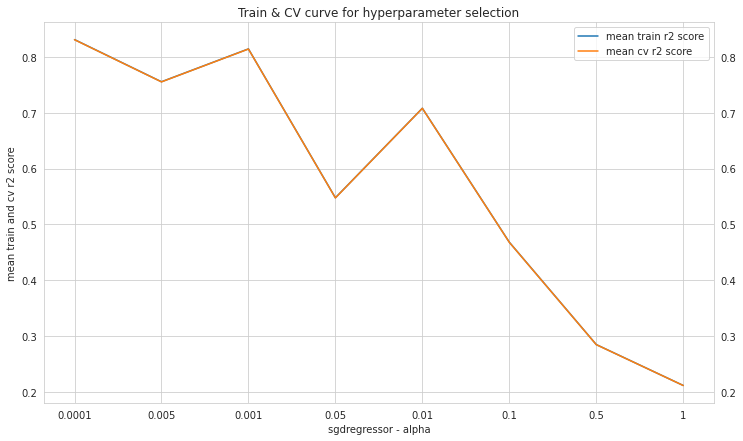

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(x=np.arange(len(params_lr['sgdregressor__alpha'])), y=clf_lr.cv_results_['mean_train_score'], label='mean train r2 score')
sns.lineplot(x=np.arange(len(params_lr['sgdregressor__alpha'])), y=clf_lr.cv_results_['mean_test_score'], label='mean cv r2 score')
plt.xticks(np.arange(len(params_lr['sgdregressor__alpha'])), labels=params_lr['sgdregressor__alpha'])
plt.tick_params(labelright=True)
plt.xlabel('sgdregressor - alpha')
plt.ylabel('mean train and cv r2 score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

Training on whole train data with selected best hyperparameter and getting r2 score for test set.

In [ ]:
clf_lr.cv_results_['mean_train_score'][0], clf_lr.cv_results_['mean_test_score'][0]

(0.8308666546382172, 0.8306093446769133)

In [ ]:
x_test = X_test.drop(columns=['id','item_date','customer','country','item type','material_ref'])
x_test = x_test.dropna()
y_test_ = y_test.values[x_test.index]

In [ ]:
pipe_lr.set_params(**clf_lr.cv_results_['params'][0] ) #selecting hyperparameter alpha=0.0001
pipe_lr.fit(x,y)
y_predict_train = pipe_lr.predict(x)
y_predict_test = pipe_lr.predict(x_test)
r2_train = r2_score(y, y_predict_train )
r2_test = r2_score(y_test_, y_predict_test )
print('Train R2 Score:', r2_train)
print('Test R2 Score:', r2_test )

Train R2 Score: 0.8312641744603999
Test R2 Score: 0.8274677528682686


**Feature Importance:**

In [ ]:
weights_lr = abs(pipe_lr.named_steps.sgdregressor.coef_)
weights_lr_sort = np.argsort(weights_lr)[::-1]
onehot_features = pipe_lr.named_steps.columntransformer.transformers_[1][1].get_feature_names_out()

In [ ]:
onehot_features[weights_lr_sort[np.where(weights_lr_sort>2)[0]]-3][:20] , weights_lr[weights_lr_sort[np.where(weights_lr_sort>2)[0]]][:20]

(array(['status_Revised', 'status_Not lost for AM', 'status_Won',
        'status_Lost', 'status_To be approved', 'status_Offered',
        'delivery date_20211001.0', 'delivery date_20210901.0',
        'product_ref_1721130331', 'delivery date_20210801.0',
        'delivery date_20200801.0', 'status_Offerable',
        'delivery date_20200901.0', 'delivery date_20210701.0',
        'delivery date_20200701.0', 'delivery date_20210601.0',
        'product_ref_640665', 'delivery date_20210501.0',
        'delivery date_20201001.0', 'delivery date_20201101.0'],
       dtype=object),
 array([882.60, 882.06, 876.16, 873.65, 828.87, 646.90, 341.40, 276.44,
        228.63, 220.90, 188.39, 186.65, 183.77, 182.17, 163.88, 150.02,
        137.15, 133.57, 131.29, 130.18]))

In [ ]:
# top 10 important features
l=pd.DataFrame()
l['feature'] = onehot_features[weights_lr_sort[np.where(weights_lr_sort>2)[0]]-3][:10]
l['weights'] = weights_lr[weights_lr_sort[np.where(weights_lr_sort>2)[0]]][:10]
l

,feature,weights
0,status_Revised,882.599576
1,status_Not lost for AM,882.062112
2,status_Won,876.160532
3,status_Lost,873.645612
4,status_To be approved,828.870774
5,status_Offered,646.896186
6,delivery date_20211001.0,341.402807
7,delivery date_20210901.0,276.438763
8,product_ref_1721130331,228.630275
9,delivery date_20210801.0,220.896360


We see that high anova f value features are more important as they are good in explaining variance in selling_price value.

**Decision Tree:**

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
pipe_dt = make_pipeline( transform , DecisionTreeRegressor())
params_dt = {'decisiontreeregressor__max_depth':[3,5,7,9,11,13,15,17,19,21]}
                      
clf_dt = GridSearchCV( pipe_dt, params_dt, cv=3, return_train_score=True, refit=False,verbose=4,scoring='r2') 
clf_dt.fit(x,y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END decisiontreeregressor__max_depth=3;, score=(train=0.368, test=0.368) total time=   0.8s
[CV 2/3] END decisiontreeregressor__max_depth=3;, score=(train=0.370, test=0.365) total time=   0.8s
[CV 3/3] END decisiontreeregressor__max_depth=3;, score=(train=0.368, test=0.370) total time=   0.8s
[CV 1/3] END decisiontreeregressor__max_depth=5;, score=(train=0.498, test=0.502) total time=   1.4s
[CV 2/3] END decisiontreeregressor__max_depth=5;, score=(train=0.502, test=0.495) total time=   1.4s
[CV 3/3] END decisiontreeregressor__max_depth=5;, score=(train=0.501, test=0.499) total time=   1.6s
[CV 1/3] END decisiontreeregressor__max_depth=7;, score=(train=0.618, test=0.617) total time=   1.6s
[CV 2/3] END decisiontreeregressor__max_depth=7;, score=(train=0.615, test=0.604) total time=   1.1s
[CV 3/3] END decisiontreeregressor__max_depth=7;, score=(train=0.617, test=0.612) total time=   1.1s
[CV 1/3] END decisiontreeregre

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('powertransformer',
                                                                         PowerTransformer(),
                                                                         (0, 3,
                                                                          4)),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         (1, 2,
                                                                          5,
                                                                          6))])),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'decisiontreeregressor__max_depth': [3, 5, 7, 9, 11,
                                                              13, 15, 17, 19,
                                                              21]},
             refit=False, return_train_score=True, scoring='r2', verbose=4)

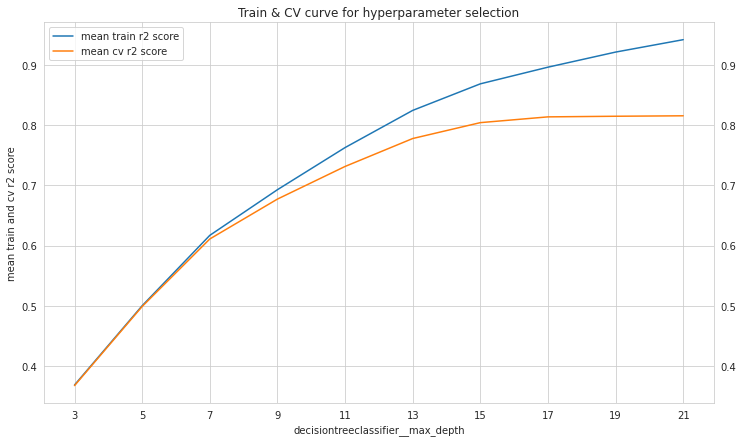

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(x=np.arange(len(params_dt['decisiontreeregressor__max_depth'])), y=clf_dt.cv_results_['mean_train_score'], label='mean train r2 score')
sns.lineplot(x=np.arange(len(params_dt['decisiontreeregressor__max_depth'])), y=clf_dt.cv_results_['mean_test_score'], label='mean cv r2 score')
plt.xticks(np.arange(len(params_dt['decisiontreeregressor__max_depth'])), labels=params_dt['decisiontreeregressor__max_depth'])
plt.tick_params(labelright=True)
plt.xlabel('decisiontreeclassifier__max_depth')
plt.ylabel('mean train and cv r2 score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

In [ ]:
clf_dt.cv_results_['mean_train_score'][6] , clf_dt.cv_results_['mean_test_score'][6]

(0.8686520659486394, 0.8042083695740239)

We will not do any further analysis for decision tree

**Random Forest:**

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
pipe_rf = make_pipeline( transform , RandomForestRegressor(random_state=50) )

search_space_rf = {
         'randomforestregressor__max_depth':(1,10),
         'randomforestregressor__n_estimators':(3,50),
         }

opt_rf = BayesSearchCV(pipe_rf, search_space_rf , n_iter=10, cv=3, verbose=4,return_train_score=True,refit=False,random_state=55,scoring='r2')

opt_rf.fit(x,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END randomforestregressor__max_depth=8, randomforestregressor__n_estimators=39;, score=(train=0.665, test=0.660) total time=  26.3s
[CV 2/3] END randomforestregressor__max_depth=8, randomforestregressor__n_estimators=39;, score=(train=0.668, test=0.653) total time=  30.8s
[CV 3/3] END randomforestregressor__max_depth=8, randomforestregressor__n_estimators=39;, score=(train=0.667, test=0.658) total time=  19.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END randomforestregressor__max_depth=5, randomforestregressor__n_estimators=7;, score=(train=0.504, test=0.507) total time=   2.0s
[CV 2/3] END randomforestregressor__max_depth=5, randomforestregressor__n_estimators=7;, score=(train=0.506, test=0.499) total time=   1.9s
[CV 3/3] END randomforestregressor__max_depth=5, randomforestregressor__n_estimators=7;, score=(train=0.504, test=0.502) total time=   2.0s
Fitting 3 folds for each of 1 candidate

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('powertransformer',
                                                                          PowerTransformer(),
                                                                          (0, 3,
                                                                           4)),
                                                                         ('onehotencoder',
                                                                          OneHotEncoder(drop='first',
                                                                                        handle_unknown='ignore'),
                                                                          (1, 2,
                                                                           5,
                                                                           6))])),
                                        ('randomforestregressor',
                                         RandomForestRegressor(random_state=50))]),
              n_iter=10, random_state=55, refit=False, return_train_score=True,
              scoring='r2',
              search_spaces={'randomforestregressor__max_depth': (1, 10),
                             'randomforestregressor__n_estimators': (3, 50)},
              verbose=4)

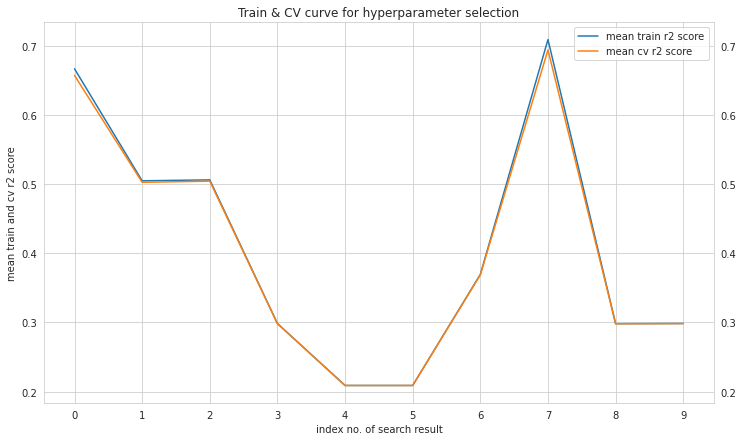

In [ ]:
n_iter=10
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(x=np.arange(n_iter), y=opt_rf.cv_results_['mean_train_score'], label='mean train r2 score')
sns.lineplot(x=np.arange(n_iter), y=opt_rf.cv_results_['mean_test_score'], label='mean cv r2 score')
plt.xticks(np.arange(n_iter))
plt.tick_params(labelright=True)
plt.xlabel('index no. of search result')
plt.ylabel('mean train and cv r2 score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

In [ ]:
opt_rf.cv_results_['params'][7] #getting values for index 7

OrderedDict([('randomforestregressor__max_depth', 9),
             ('randomforestregressor__n_estimators', 25)])

In [ ]:
opt_rf.cv_results_['mean_train_score'][7] , opt_rf.cv_results_['mean_test_score'][7]

(0.7088381053917453, 0.6939147685110779)

we will not do any further analysis

**XGBoost:**

In [ ]:
pipe_xgb = make_pipeline( transform , XGBRegressor( random_state=15, objective='reg:squarederror') )

search_space_xgb = {
         'xgbregressor__max_depth':(1,10),
         'xgbregressor__n_estimators':(3,50),
         'xgbregressor__learning_rate':(0.1, .99, 'uniform'),
         'xgbregressor__subsample':(0.7, 1, 'uniform'),
         'xgbregressor__colsample_bytree':(0.7, 1, 'uniform'),
         'xgbregressor__lambda':(1e-4, 1e+3,'log-uniform'),
         'xgbregressor__scale_pos_weight':(0.15,.99,'uniform')
         }

opt_xgb = BayesSearchCV(pipe_xgb, search_space_xgb , n_iter=10, cv=3, verbose=4,return_train_score=True,refit=False,random_state=55,scoring='r2')

opt_xgb.fit(x,y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END xgbregressor__colsample_bytree=1, xgbregressor__lambda=20.936646688240696, xgbregressor__learning_rate=0.9012993298149262, xgbregressor__max_depth=2, xgbregressor__n_estimators=16, xgbregressor__scale_pos_weight=0.34972928137407544, xgbregressor__subsample=1;, score=(train=0.649, test=0.652) total time=   1.3s
[CV 2/3] END xgbregressor__colsample_bytree=1, xgbregressor__lambda=20.936646688240696, xgbregressor__learning_rate=0.9012993298149262, xgbregressor__max_depth=2, xgbregressor__n_estimators=16, xgbregressor__scale_pos_weight=0.34972928137407544, xgbregressor__subsample=1;, score=(train=0.650, test=0.648) total time=   1.1s
[CV 3/3] END xgbregressor__colsample_bytree=1, xgbregressor__lambda=20.936646688240696, xgbregressor__learning_rate=0.9012993298149262, xgbregressor__max_depth=2, xgbregressor__n_estimators=16, xgbregressor__scale_pos_weight=0.34972928137407544, xgbregressor__subsample=1;, score=(train=0.65

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('powertransformer',
                                                                          PowerTransformer(),
                                                                          (0, 3,
                                                                           4)),
                                                                         ('onehotencoder',
                                                                          OneHotEncoder(drop='first',
                                                                                        handle_unknown='ignore'),
                                                                          (1, 2,
                                                                           5,
                                                                           6))])),
                                        ('xgbregressor',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      col...
              scoring='r2',
              search_spaces={'xgbregressor__colsample_bytree': (0.7, 1,
                                                                'uniform'),
                             'xgbregressor__lambda': (0.0001, 1000.0,
                                                      'log-uniform'),
                             'xgbregressor__learning_rate': (0.1, 0.99,
                                                             'uniform'),
                             'xgbregressor__max_depth': (1, 10),
                             'xgbregressor__n_estimators': (3, 50),
                             'xgbregressor__scale_pos_weight': (0.15, 0.99,
                                                                'uniform'),
                             'xgbregressor__subsample': (0.7, 1, 'uniform')},
              verbose=4)

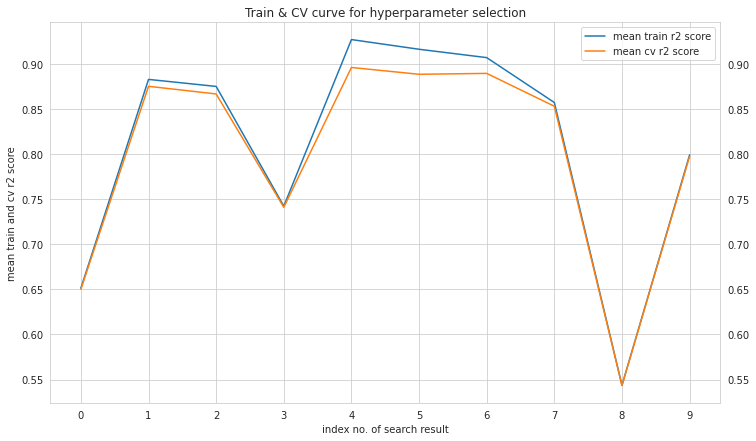

In [ ]:
n_iter=10
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(n_iter), y=opt_xgb.cv_results_['mean_train_score'], label='mean train r2 score')
sns.lineplot(np.arange(n_iter), y=opt_xgb.cv_results_['mean_test_score'], label='mean cv r2 score')
plt.xticks(np.arange(n_iter))
plt.tick_params(labelright=True)
plt.xlabel('index no. of search result')
plt.ylabel('mean train and cv r2 score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

Getting r2 score for full train data and unseen test data using best hyperparameter from above plot.

In [ ]:
opt_xgb.cv_results_['mean_train_score'][4] , opt_xgb.cv_results_['mean_test_score'][4]

(0.9268656037869113, 0.8959333712543035)

In [ ]:
param=opt_xgb.cv_results_['params'][4] # selecting index no. 4 from above plot
param

OrderedDict([('xgbregressor__colsample_bytree', 1),
             ('xgbregressor__lambda', 0.007236023606980012),
             ('xgbregressor__learning_rate', 0.5778248256728152),
             ('xgbregressor__max_depth', 9),
             ('xgbregressor__n_estimators', 42),
             ('xgbregressor__scale_pos_weight', 0.7908310769150846),
             ('xgbregressor__subsample', 1)])

In [ ]:
pipe_xgb.set_params(**param)
pipe_xgb.fit(x,y)
y_predict_train = pipe_xgb.predict(x)
y_predict_test = pipe_xgb.predict(x_test)
r2_train = r2_score(y, y_predict_train )
r2_test = r2_score(y_test_, y_predict_test )
print('Train R2 Score:', r2_train)
print('Test R2 Score:', r2_test )

Train R2 Score: 0.9231371993472588
Test R2 Score: 0.9017034660315767


**Feature Importance:**

In [ ]:
impt = pipe_xgb.named_steps.xgbregressor.feature_importances_
sorted_impt = np.argsort(impt)[::-1]

In [ ]:
sorted_impt_onehot = sorted_impt[np.where(sorted_impt>2)[0]]-3

In [ ]:
xg = pd.DataFrame() # top 10 impt. features
xg['features'] = onehot_features[sorted_impt_onehot[:10]]
xg['normalized impt. value'] = impt[sorted_impt_onehot[:10]+3]
xg

,features,normalized impt. value
0,product_ref_611993,0.123631
1,delivery date_20210801.0,0.080308
2,status_To be approved,0.073519
3,delivery date_20210701.0,0.070179
4,delivery date_20210901.0,0.050021
5,delivery date_20210501.0,0.044359
6,delivery date_20210601.0,0.040222
7,delivery date_20200801.0,0.039318
8,delivery date_20211001.0,0.038207
9,status_Revised,0.035667


**Deep Neural Network:**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
X_trn, X_val, y_trn, y_val = train_test_split(x, y, test_size=0.10,random_state=92) #splitting train into train and val

In [ ]:
X_trn = transform.fit_transform(X_trn).toarray() #transforming 
X_val = transform.transform(X_val).toarray()

In [ ]:
input_layer = Input(shape=(X_trn.shape[1],))
layer1 = Dense(512,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(22))(input_layer)
layer2 = Dense(256,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(47))(layer1)
layer3 = Dense(128,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(85))(layer2)
layer4 = Dense(64,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(57))(layer3)
layer5 = Dense(32,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(75))(layer4)
layer6 = Dense(16,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(89))(layer5)
output = Dense(1,activation=None,kernel_initializer=tf.keras.initializers.HeNormal(95))(layer6)
model = Model(inputs=input_layer,outputs=output)

In [ ]:
!pip install tensorflow-addons

In [ ]:
import tensorflow_addons as tfa

In [ ]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=[tfa.metrics.r_square.RSquare()])

model_hist = model.fit(X_trn,y_trn,epochs=20, validation_data=(X_val,y_val), batch_size=1024)

Epoch 1/20
144/144 [==============================] - 5s 30ms/step - loss: 139149.0000 - r_square: -1.7486 - val_loss: 19986.8516 - val_r_square: 0.6107
Epoch 2/20
144/144 [==============================] - 5s 35ms/step - loss: 16327.1318 - r_square: 0.6775 - val_loss: 14372.2666 - val_r_square: 0.7201
Epoch 3/20
144/144 [==============================] - 4s 29ms/step - loss: 11445.1670 - r_square: 0.7739 - val_loss: 9507.2881 - val_r_square: 0.8148
Epoch 4/20
144/144 [==============================] - 4s 28ms/step - loss: 7661.6602 - r_square: 0.8487 - val_loss: 6947.0249 - val_r_square: 0.8647
Epoch 5/20
144/144 [==============================] - 6s 43ms/step - loss: 6484.5166 - r_square: 0.8719 - val_loss: 6525.3159 - val_r_square: 0.8729
Epoch 6/20
144/144 [==============================] - 4s 28ms/step - loss: 6196.0474 - r_square: 0.8776 - val_loss: 6334.3193 - val_r_square: 0.8766
Epoch 7/20
144/144 [==============================] - 4s 30ms/step - loss: 6029.6758 - r_square: 0.

In [ ]:
model.fit(X_trn,y_trn,epochs=30, validation_data=(X_val,y_val), batch_size=1024, initial_epoch=20)

Epoch 21/30
144/144 [==============================] - 4s 28ms/step - loss: 5291.2583 - r_square: 0.8955 - val_loss: 5623.0620 - val_r_square: 0.8905
Epoch 22/30
144/144 [==============================] - 6s 42ms/step - loss: 5270.7231 - r_square: 0.8959 - val_loss: 5553.4609 - val_r_square: 0.8918
Epoch 23/30
144/144 [==============================] - 4s 28ms/step - loss: 5218.1011 - r_square: 0.8969 - val_loss: 5615.9126 - val_r_square: 0.8906
Epoch 24/30
144/144 [==============================] - 4s 31ms/step - loss: 5184.1060 - r_square: 0.8976 - val_loss: 5623.9141 - val_r_square: 0.8905
Epoch 25/30
144/144 [==============================] - 4s 31ms/step - loss: 5209.4980 - r_square: 0.8971 - val_loss: 5563.9800 - val_r_square: 0.8916
Epoch 26/30
144/144 [==============================] - 4s 29ms/step - loss: 5164.4238 - r_square: 0.8980 - val_loss: 5644.2505 - val_r_square: 0.8901
Epoch 27/30
144/144 [==============================] - 5s 34ms/step - loss: 5162.7148 - r_square: 0.

In [ ]:
model.fit(X_trn,y_trn,epochs=40, validation_data=(X_val,y_val), batch_size=1024, initial_epoch=30)

Epoch 31/40
144/144 [==============================] - 5s 36ms/step - loss: 5056.7451 - r_square: 0.9001 - val_loss: 5452.1016 - val_r_square: 0.8938
Epoch 32/40
144/144 [==============================] - 4s 28ms/step - loss: 5161.2354 - r_square: 0.8981 - val_loss: 5568.0659 - val_r_square: 0.8915
Epoch 33/40
144/144 [==============================] - 4s 28ms/step - loss: 5054.9976 - r_square: 0.9002 - val_loss: 5432.7759 - val_r_square: 0.8942
Epoch 34/40
144/144 [==============================] - 5s 35ms/step - loss: 5063.4272 - r_square: 0.9000 - val_loss: 5416.2847 - val_r_square: 0.8945
Epoch 35/40
144/144 [==============================] - 4s 29ms/step - loss: 5007.2104 - r_square: 0.9011 - val_loss: 5373.0146 - val_r_square: 0.8953
Epoch 36/40
144/144 [==============================] - 4s 28ms/step - loss: 5016.1455 - r_square: 0.9009 - val_loss: 5346.0791 - val_r_square: 0.8959
Epoch 37/40
144/144 [==============================] - 5s 34ms/step - loss: 4975.7925 - r_square: 0.

In [ ]:
model.fit(X_trn,y_trn,epochs=50, validation_data=(X_val,y_val), batch_size=1024, initial_epoch=40)

Epoch 41/50
144/144 [==============================] - 5s 35ms/step - loss: 4930.7803 - r_square: 0.9026 - val_loss: 5378.5718 - val_r_square: 0.8952
Epoch 42/50
144/144 [==============================] - 4s 28ms/step - loss: 4929.3770 - r_square: 0.9026 - val_loss: 5333.3687 - val_r_square: 0.8961
Epoch 43/50
144/144 [==============================] - 5s 34ms/step - loss: 4957.0464 - r_square: 0.9021 - val_loss: 5348.9868 - val_r_square: 0.8958
Epoch 44/50
144/144 [==============================] - 4s 30ms/step - loss: 4918.2886 - r_square: 0.9029 - val_loss: 5372.8389 - val_r_square: 0.8953
Epoch 45/50
144/144 [==============================] - 4s 30ms/step - loss: 4945.9990 - r_square: 0.9023 - val_loss: 5453.2988 - val_r_square: 0.8938
Epoch 46/50
144/144 [==============================] - 5s 35ms/step - loss: 4906.9780 - r_square: 0.9031 - val_loss: 5368.4038 - val_r_square: 0.8954
Epoch 47/50
144/144 [==============================] - 5s 35ms/step - loss: 4916.7456 - r_square: 0.

In [ ]:
y_pred = model.predict(transform.transform(x).toarray())

5108/5108 [==============================] - 9s 2ms/step


In [ ]:
y_pred_test = model.predict(transform.transform(x_test).toarray())

 16/568 [..............................] - ETA: 1s 

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


568/568 [==============================] - 1s 3ms/step


In [ ]:
r2_score(y,y_pred) , r2_score(y_test_,y_pred_test)

(0.902023733212354, 0.8932957545898542)

Have made a basic neural network and for now not optimizing it further.

**OLS StatsModel:**

- statsmodels module gives some extra statistical values which can be used for further analysis.

In [ ]:
import statsmodels.api as sm
est = sm.OLS(y,transform.fit_transform(x).toarray())
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:          selling_price   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                          1.417e+05
Date:                Sun, 12 Mar 2023   Prob (F-statistic):                        0.00
Time:                        23:13:31   Log-Likelihood:                     -9.6974e+05
No. Observations:              163434   AIC:                                  1.940e+06
Df Residuals:                  163336   BIC:                                  1.941e+06
Df Model:                          98                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
transform.output_indices_

{'powertransformer': slice(0, 3, None),
 'onehotencoder': slice(3, 98, None),
 'remainder': slice(0, 0, None)}

In [ ]:
l #linear regression top features

,feature,weights
0,status_Revised,882.599576
1,status_Not lost for AM,882.062112
2,status_Won,876.160532
3,status_Lost,873.645612
4,status_To be approved,828.870774
5,status_Offered,646.896186
6,delivery date_20211001.0,341.402807
7,delivery date_20210901.0,276.438763
8,product_ref_1721130331,228.630275
9,delivery date_20210801.0,220.896360


In [ ]:
onehot_features

array(['status_Lost', 'status_Not lost for AM', 'status_Offerable',
       'status_Offered', 'status_Revised', 'status_To be approved',
       'status_Won', 'status_Wonderful', 'application_3.0',
       'application_4.0', 'application_5.0', 'application_10.0',
       'application_15.0', 'application_19.0', 'application_20.0',
       'application_22.0', 'application_25.0', 'application_26.0',
       'application_27.0', 'application_28.0', 'application_29.0',
       'application_38.0', 'application_39.0', 'application_40.0',
       'application_41.0', 'application_42.0', 'application_56.0',
       'application_58.0', 'application_59.0', 'application_65.0',
       'application_66.0', 'application_67.0', 'application_68.0',
       'application_69.0', 'application_70.0', 'application_79.0',
       'application_99.0', 'product_ref_611733', 'product_ref_611993',
       'product_ref_628112', 'product_ref_628117', 'product_ref_628377',
       'product_ref_640400', 'product_ref_640405', 'product

<font color ='red'>Observation:
- If we compare statsmodel data and onehot features we see that 'application' feature(x12-x41) have many high p-value and corresponding less confident(wide) confidence interval.
- 'application' feature(x12-x41) had lowest anova f score among selected top 4 categorical features, which is also reflected in above statistical values.
- 3 numerical features(x1-x3) show moderate statistical values with good confidence interval.
- 'status' feature(x4-x11) have many high t value.
- We see that x6,x11 feature from status do not appear in linear regression top features as they have low t and wide C.I.